# Positional Cross-Match Test Notebook #

This is a short notebook to run a simple positional cross-match between two catalogues, and links to the following confluence page ([Positional cross-matching on multi-wave data test](https://confluence.skatelescope.org/pages/viewpage.action?pageId=319985104)). This example uses the LOFAR Virgo Cluster Survey data set for the radio catalogue ([Virgo Cluster Survey](https://lofar-surveys.org/virgo_data.html)), and PanSTARRS ([PanSTARRS home page](https://outerspace.stsci.edu/display/PANSTARRS/)) for the optical data. The user is welcome to use any catalogues they have to hand.

This notebook uses `astropy SkyCoord`'s `match_to_catalog_sky` to find the closest on-sky sources by RA and DEC and filter this down to those matches which are less than *1.5 arcsecs* in distance. The notebook is broken down into the following sections: 
- Imports
    - This cell contains all the imports required.
- Load in files
    - This section loads in the files that are stored in the data system. For this example, the LOFAR Virgo Cluster survey catalogue is available, and a small filter PanSTARRs catalogue has been downloaded. If the PanSTARRS catalogue is not available, this example requires the use of `astroquery` to run a search through PanSTARRS around the given area. Be aware **this will max at the first 50 rows** and therefore may not produce may matches inside the given area. The area for the radio catalogue has been chosen as a 2 degree circle at the centre of the survey. The PanSTARRS data, is selected to be slightly larger to allow for boundary effects. If the user choses their own catalogues the appropriate paths ways or astroquery must be used at this stage.
- Catalogue information check and setup
    - This is a quick check on what the columns and units of the catalogues are, and follows by setting the column names for the rest of the notebook. If the user chooses to use different catalogues the column names need to be changed at this location.
- Sky area plots to check coverage
    - These plots will check the coverage of the catalogues. This is important to make sure that the loaded data overlaps, and that the filtered radio catalogue covers a slightly smaller area than optical catalogue. In the example these plots should be as on the confluence page. In the case the user has their own data, it is a check that the catalogues cover the same sky area. These can be saved.
- Positional cross match
    - This section does the cross-matching using the RA and DEC positions in each catalogue. It find the closest on-sky optical source for the filtered radio catalogue. These matches are then filtered to only those counterparts which are within 1.5 arcsecs of each other. A new table of the matches is made, comtaining all the columns from both the radio and optical catalogues, and a column containing the on-sky separation between the two sources in arcseconds.
- Plot the results
    - The results are visualised in two plots. The first plot is a bar chart showing the number of matching pairs which have an on-sky separation within in each 0.1 arcsec bin. The second shows the position of the matched radio source, and these are shaded according to their on-sky separation from their matched optical source. In this plot, the darker the radio source position the further the optical match is.


In [1]:
# Imports
from astropy.table import Table
from astropy.coordinates import SkyCoord
import astropy.units as u
from astroquery.vizier import Vizier
from astropy.table import Table, vstack
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_palette('dark')
palette = sns.color_palette('dark')


## Load in files

Firstly the files need to be loaded. Here the radio catalogue should be uploaded to the SKA storage. The optical data can either be the one stored or can be searched for using `astroquery`. Be aware that `astroquery` will restrict the search to the first 50 rows, despite being set to unlimit rows requested.

The second half of the cell sets the parameters for the search. The optical radius is used *if* astroquery is required, otherwise the optical catalogue provided covers this area. The optical catalogue was generated (or will be generated) to be slightly larger than the radio radius This is to counter for boundary effects where the closet match maybe further away from the centre location.

In [3]:
# Load files - radio is uploaded to Rucio. Optical is either uploaded to Rucio or Panstarrs can be queried using astroquery but restricts to only the first 50 rows.

radio_path = '/project/test_campaign/test_datasets/lofar_virgo_full.fits'                                              # Adjust file path for storage location
radio_cat = Table.read(radio_path)                                                              # Read in radio catalogue as astropy table
optical_path = '/project/test_campaign/test_datasets/panstarrs_2deg.fits'                                              # Adjust file path for storage location
optical_cat = Table.read(optical_path)                                                          # Read in optical catalogue as astropy table comment out if using astroquery

# Setting the save location for any tables and plots that want to be saved
save_path = '/project/test_campaign/res'                                                                    # Add path to save any plots and tables

# Setting the parameters for the search - radius and centre location
centre_coords = SkyCoord(ra = 187.5 * u.deg, dec = 10.0 * u.deg, frame='icrs')                  # Defining the centre coordinates
opt_rad = 2.1 * u.deg                                                                           # Selecting a slightly larger optical radius than a radio one
rad_rad = 2 * u.deg                                                                             # Selecting a slightly smaller radio radius than an optical one


In [4]:
# Finding Panstarrs via astroquery - uncomment this cell and run if need be
#Vizier.ROW_LIMIT = -1                                                                           # Selects all the rows of the query max at 50
#vizier = Vizier()                                                                               # Selects the default columns (only need ra and dec) otherwise columns = ['*']
#pans_cat_id = 'II/349/ps1'                                                                      # Panstarrs catalogue ID

#pans_result = vizier.query_region(centre_coords, radius = opt_rad, catalog = pans_cat_id)       # Calling and searching in the Panstarrs cat for everying in a 2.1 deg radius

# Determines if any sources were found after the query
#if not pans_result:
#    print("No Pan-STARRS sources found.")                                                       # Prints if no sources are found
#else:
#    panstarrs_table = pans_result[0]                                                            # Read the first column
#    print(f"Found {len(panstarrs_table)} Pan-STARRS sources")                                   # Print the length of the first column to give the number of sources

#optical_cat = pans_result[0]                                                                    # Assign the astroquery result to optical_cat instead of the stored catalogue 

## Catalogue information check and column set up ##

The following is a quick check on the catalogues that have been loaded in. This is important for checking the name of the columns and the units that may be assigned.
This notebook focuses on using the RA and DEC from each catalogue, this mean the name of these columns is needed and any units assigned have to be checked.
If the given LOFAR and Panstarrs catalogues are used then the following column names and units are used through out the notebook.

In [5]:
# Print the first few column names, types, and units.
opt_cols = optical_cat[optical_cat.colnames[:8]].info()
rad_cols = radio_cat[radio_cat.colnames[:8]].info()

<Table length=290124>
  name    dtype  unit
-------- ------- ----
_RAJ2000 float64  deg
_DEJ2000 float64  deg
      _r float64     
 RAJ2000 float64  deg
 DEJ2000 float64  deg
   objID   int64     
 f_objID   int64     
    Qual   int16     
<Table length=11201>
    name      dtype  unit
------------ ------- ----
   Source_id   int32     
      Isl_id   int32     
          RA float64  deg
        E_RA float64  deg
         DEC float64  deg
       E_DEC float64  deg
  Total_flux float64   Jy
E_Total_flux float64   Jy


In [6]:
# Define the column names and note the units assigned to it
RRA_col = 'RA'                                                                                      # The column name for the radio RA - units: degs
RDEC_col = 'DEC'                                                                                    # The column name for the radio DEC - units: degs
ORA_col = 'RAJ2000'                                                                                 # The column name for the optical RA - units: degs
ODEC_col = 'DEJ2000'                                                                                # The column name for the optical DEC - units: degs

The following cell sets up the coordinates and radio catalogue for the positional cross matching. In order to do the cross matching the RA and DEC columns in each catalogue have to be defined as pairs of `SkyCoord` coordinates. In the case of the given catalogues they already have units, so no units need to be assigned.

Following from this the radio catalogue is then filtered to all sources within given radius from the centre point, and the the new catalogue has the RA and DEC defined as `SkyCoord` coordinates.

In [7]:
# Setting up the coordinates
radio_coords = SkyCoord(ra = radio_cat[RRA_col], dec = radio_cat[RDEC_col])                         # The radio catalogue has the units of degs - divide to take to arcsec
optical_coords = SkyCoord(ra = optical_cat[ORA_col], dec = optical_cat[ODEC_col])                   # The optical catalogue has units of degs - divide to take to arcsec

# Filter the radio catalogue to just under the optical catalogue size
rad_sep = centre_coords.separation(radio_coords)                                                    # The separations between the centre and each source in the radio catalogue

filtered_rad_cat = radio_cat[rad_sep <= rad_rad]                                                    # Filter the radio catalogue to within the 2-degree radius

filtered_radio_coords = SkyCoord(ra = filtered_rad_cat[RRA_col], dec = filtered_rad_cat[RDEC_col])  # Coords for filtered catalogue

## Sky area plots to check coverage ##

Next is a simple check that all the catalogues makes sense. First, the full radio catalogue is plotted with the full optical catalogue overlaid. This is to check that the inputted optical catalogue overlaps the radio catalogue. Secondly, the filtered radio catalogue is plotted overlaying the optical catalogue. Again, this is to check that both catalogues overlap each other, and that there is a reasonable number of radio sources in the overlapping area that can be matched to an optical source.

As this is over a small sky area and is only a check, they are plotted in degrees.

FileNotFoundError: [Errno 2] No such file or directory: '/path/to/data/Xmatch_test_fullcoverage.png'

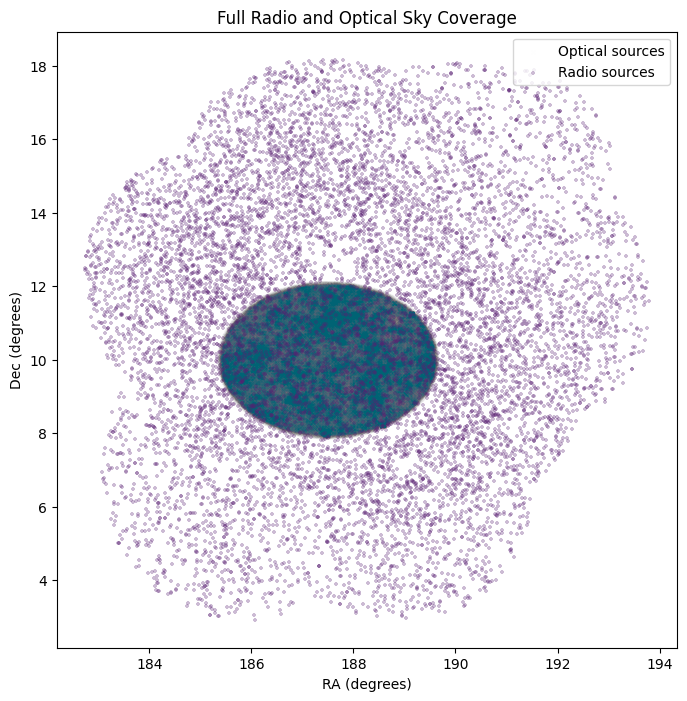

In [8]:
# Start by plotting the full radio and optical catalogues available
fig, ax1 = plt.subplots(figsize=(8, 8))                                                             # Setting the figure and size

# Plot the optical sources as a scatter diagram using the SkyCoord coordinates (in degrees)
ax1.scatter(optical_coords.ra.deg, optical_coords.dec.deg, color = palette[9], label='Optical sources', s = 10, alpha = 0.003, marker = 'x')

# Plot the radio sources as a scatter diagram using the SkyCoord coordinates (in degrees)
ax1.scatter(radio_coords.ra.deg, radio_coords.dec.deg, color = palette[4], label = 'Radio sources', s = 10, alpha = 0.3, marker = '+')

ax1.set_xlabel('RA (degrees)')
ax1.set_ylabel('Dec (degrees)')
ax1.set_title('Full Radio and Optical Sky Coverage')
ax1.legend(loc='upper right')
plt.savefig(save_path+'Xmatch_test_fullcoverage.png', dpi = 300)                                               # Save the figure if uncommented
plt.show()

# Now plot the filtered radio and optical catalogues
fig, ax2 = plt.subplots(figsize=(8, 8))

# Plot the optical sources as a scatter diagram using the SkyCoord coordinates (in degrees)
ax2.scatter(optical_coords.ra.deg, optical_coords.dec.deg, color = palette[9], label='Optical sources', s = 10, alpha = 0.03, marker = 'x')

# Plot the filtered radio sources as a scatter diagram using the SkyCoord coordinates (in degrees)
ax2.scatter(filtered_radio_coords.ra.deg, filtered_radio_coords.dec.deg, color = palette[4], label = 'Filtered Radio sources', s = 10, alpha = 0.5, marker = '+')

ax2.set_xlabel('RA (degrees)')
ax2.set_ylabel('Dec (degrees)')
ax2.set_title('Filtered Radio and Optical Sky Coverage')
ax2.legend(loc='upper right')
plt.savefig(save_path+'Xmatch_test_filteredcoverage.png', dpi = 300)                                           # Save the figure if uncommented
plt.show()

## Positional cross-matching ##
The next cell does a positional cross match between the radio and optical catalogue using the RA and DEC from each. The single line of code that does the cross matching finds the closest source in the optical catalogue to each source in the radio catalogue.

This is then filtered further to only apply to sources that have an on-sky separation of less than *1.5 arcsecs*. These matched sources are then stored in a new table, and the total number of matches is printed.


In [ ]:
# Positional crossmatch
idx, d2d, _ = filtered_radio_coords.match_to_catalog_sky(optical_coords)                            # Matches for the closet source between the two catalogues (filtered radio)

# Apply 1.5 arcsec threshold
max_sep = 1.5 * u.arcsec                                                                            # Set the separation at which we want the closet match           
match_mask = d2d < max_sep                                                                          # finds all sources with an on-sky separation at less than the max separation

matched_radio = filtered_rad_cat[match_mask]                                                        # Gives the radio sources with a match
matched_optical = optical_cat[idx[match_mask]]                                                      # Gives the optical sources with a match
matched_separations = d2d[match_mask]                                                               # Lists the separations of the sources with a match

# Build a combined table from the matched rows and add the separation in arcseconds
combined_table = Table()                                                                            # Makes an empty astropy table

# Add the columns from the radio and optical (radio and optical added at the from to aviod repeated column names)
for col1 in matched_radio.colnames:
    combined_table[f'radio_{col1}'] = matched_radio[col1]                                           # Adds all the radio columns for the matched sources, prefixed with radio_

for col2 in matched_optical.colnames:
    combined_table[f'optical_{col2}'] = matched_optical[col2]                                       # Adds all the optical columns for the matched source, prefixed with optical_

combined_table['separation_asec'] = matched_separations.arcsec                                      # Add the separation in arcseconds

combined_table.write(save_path+"matched_catalog.fits", format="fits", overwrite=True)               # Save the matched catalogue if uncommented

print('Number of matched sources found:',len(combined_table))                                       # Print the length of table to get number of matches found

## Plotting the results ##

Finally two plots are presented to display the outcomes of the positional cross-matching.

In the first plot is the distribution of the on-sky separation between the radio and optical matches is presented. This is a bar chart where the height of the bar represents the number of sources at a distance in 0.1 arcsec steps, upto the max of 1.5 arcsec.

The second plot shows the position of the matched radio sources (in degrees). These are shaded according to their on-sky separation from the optical source. The darker points indicate a more distant optical source.

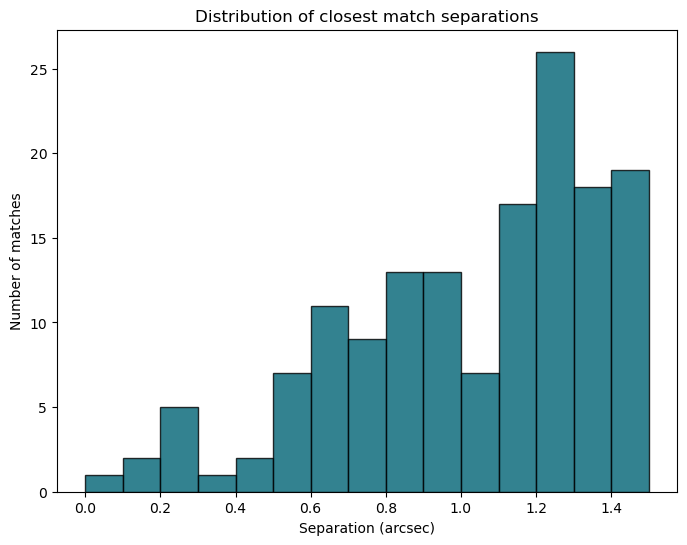

In [23]:
# Plotting the separation distance of the nearest matching sources
plt.figure(figsize = (8, 6))
bins = np.linspace(0, 1.5, 16)
plt.hist(combined_table['separation_asec'], bins = bins, edgecolor = 'k', color = palette[9], alpha = 0.8)
plt.xlabel('Separation (arcsec)')
plt.ylabel('Number of matches')
plt.title('Distribution of closest match separations')
plt.savefig(save_path+'Xmatch_test_separationdistribution.png', dpi = 300)                                         # Save the figure if uncommented
plt.show()

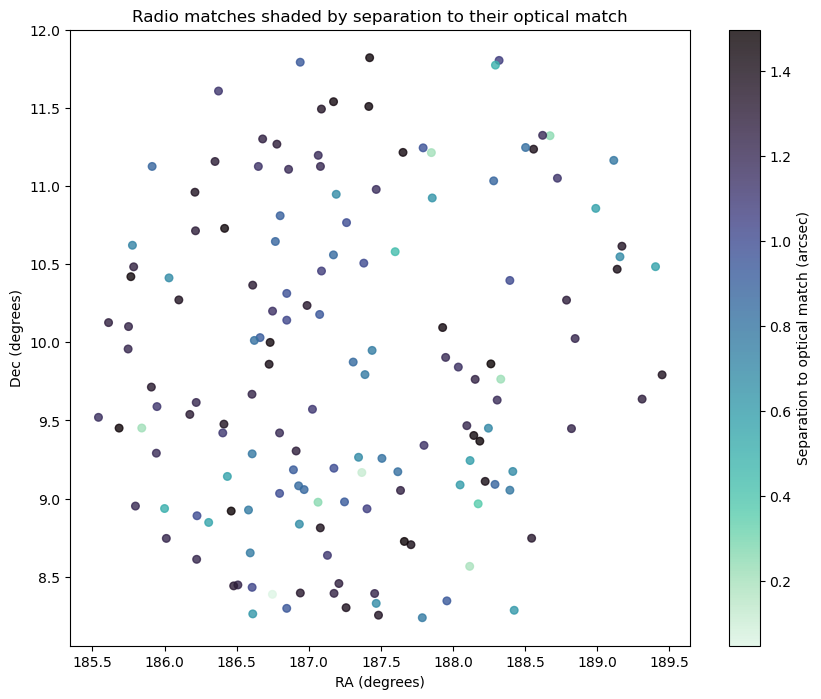

In [24]:
# Plotting the position of the radio matches, shaded according to the on-sky separation from the optical sources.
fig, ax3 = plt.subplots(figsize=(10, 8))

# Create SkyCoord objects for matched radio sources.
matched_radio_coords = SkyCoord(ra = combined_table['radio_'+RRA_col], dec = combined_table['radio_'+RDEC_col])

# Plotting the matched radio postions coloured by separation
sc = ax3.scatter(matched_radio_coords.ra.deg, matched_radio_coords.dec.deg, c = combined_table['separation_asec'], cmap = 'mako_r', s  = 30, alpha = 0.8)

cbar = plt.colorbar(sc)
cbar.set_label('Separation to optical match (arcsec)')
ax3.set_xlabel('RA (degrees)')
ax3.set_ylabel('Dec (degrees)')
ax3.set_title('Radio matches shaded by separation to their optical match')
plt.savefig(save_path+'Xmatch_test_shadedposition.png', dpi = 300)                                                 # Save the figure if uncommented
plt.show()